<a href="https://colab.research.google.com/github/Jazzi09/CNN-for-snake-bites/blob/main/PIA_RN(Preliminay_Version2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Equipo*

1992370 Hannia Medina Aguilar 

---

# PIA:
# **Modelo para clasificación de modidas de serpiente**
Curso: Redes Neuronales

---


# **I N T R O D U C C I Ó N**

En este proyecto entrenamos un modelo para clasificar mordidas de serpientes en venenosas y no venosas a partir de fotografias de las mordidas.


---
# Acceso a Drive
Primero, se habilitó el acceso a Drive.

In [ ]:
# Mounting Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



---
# Librerías
Enseguida, se importaron las librerías necesarias.

In [ ]:
# Importando librerías
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


---
# **P R E - P R O C E S A M I E N T O**
El conjunto de imágenes o "Dataset" consiste en 56 imágenes de fotografías de mordidas de serpientes venenosas y no venenosas. Fue dividido aleatoriamente en entrenamiento, validación y prueba en 70%, 10%, y 20%, respectivamente.

Se eligió dividir el conjunto de datos con estos porcentajes porque usar 20% para la prueba permite obtener una buena precisión sin sacrificar la cantidad de imágenes disponibles para entrenamiento y validación. Gholamy et. Alabama. (2018) explican el desarrollo matemático detrás de esta división.

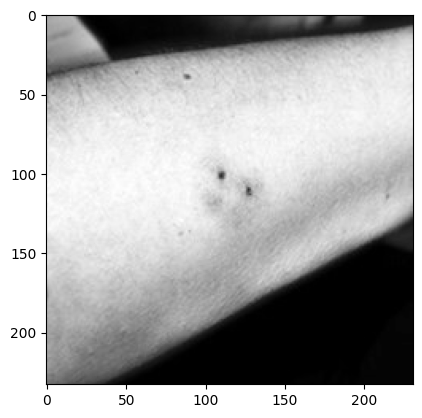

In [ ]:
# Visualizando imagen de prueba venenosa
path_im = '/content/drive/My Drive/snakeBiteAug/venenosa/snake-bites-1.jpg'
test_im = cv2.imread(path_im, cv2.IMREAD_GRAYSCALE)
plt.imshow(test_im, cmap='gray')

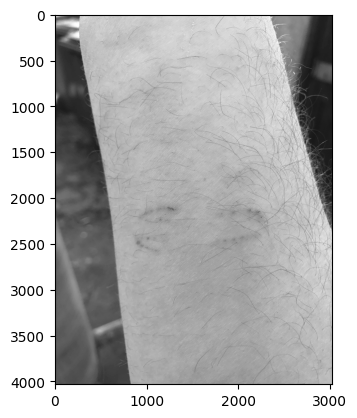

In [ ]:
# Visualizando imagen de prueba no venenosa
path_im = '/content/drive/My Drive/snakeBiteAug/noVenenosa/UmmvYf4.jpg'
test_im = cv2.imread(path_im, cv2.IMREAD_GRAYSCALE)
plt.imshow(test_im, cmap='gray')

In [ ]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Importando la librería para hacer la división a partir de las carpetas
import splitfolders

splitfolders.ratio('/content/drive/My Drive/snakeBiteAug/', # Carpeta del dataset original
                   output='/content/drive/My Drive/DatasetAug/', # Nueva carpeta para el dataset dividido
                   seed=42, # Estado del generador aleatorio
                   ratio=(0.70, 0.10, 0.20), # La proporción del conjunto de datos dividido en entrenamiento, validación, prueba
                   group_prefix=None, # Solo un formato de imágenes
                   )

Copying files: 168 files [01:43,  1.62 files/s]


In [ ]:
# Definiendo las direcciones de almacenamiento o "paths"
train_path = '/content/drive/My Drive/DatasetAug/train'
val_path = '/content/drive/My Drive/DatasetAug/val'
test_path = '/content/drive/My Drive/DatasetAug/test'

In [ ]:
# Mostrando el número de imágenes en cada subconjunto de datos
def GetDatasetSize(path):
    num_of_image = {}
    for folder in os.listdir(path):
        # Contando el número de archivos en la carpeta
        num_of_image[folder] = len(os.listdir(os.path.join(path, folder)));
    return num_of_image;
    
train_set = GetDatasetSize(train_path)
val_set = GetDatasetSize(val_path)
test_set = GetDatasetSize(test_path)
print('Train set', train_set,'\n','Validation set',val_set,'\n','Test set', test_set)

Train set {'venenosa': 62, 'noVenenosa': 54} 
 Validation set {'venenosa': 9, 'noVenenosa': 7} 
 Test set {'venenosa': 19, 'noVenenosa': 17}


La función ImageDataGenerator fue implementada para normalizar las imágenes, y también para realizar la Aumentación de Datos en el subconjunto de entrenamiento.

La función flow_from_directory fue implementada para redimensionar las imágenes a un tamaño de 256 x 256 px.

In [ ]:
# Aumentación de datos, normalización y redimensión de las imágenes de entrenamiento
train_data_augmentation = ImageDataGenerator(rescale = 1.0/255.0,
                                             horizontal_flip = True,
                                             fill_mode = 'nearest',
                                             zoom_range = 0.2,
                                             shear_range = 0.2,
                                             width_shift_range = 0.2,
                                             height_shift_range = 0.2,
                                             rotation_range=0.4)

train_data = train_data_augmentation.flow_from_directory(train_path, 
                                                         batch_size = 5,
                                                         target_size = (256,256),
                                                         class_mode = 'categorical')

Found 116 images belonging to 2 classes.


In [ ]:
# Normalización y redimensión de las imágenes de validación
val_data_gen = ImageDataGenerator(rescale = 1.0/255.0)
val_data = val_data_gen.flow_from_directory(val_path,
                                            batch_size = 5,
                                            target_size = (256,256),
                                            class_mode = 'categorical')

Found 16 images belonging to 2 classes.


In [ ]:
# Normalización y redimensión de las imágenes de prueba
test_data_gen = ImageDataGenerator(rescale = 1.0/255.0)
test_data = test_data_gen.flow_from_directory(test_path,
                                              batch_size = 5,
                                              target_size = (256,256),
                                              class_mode = 'categorical')

Found 36 images belonging to 2 classes.


In [ ]:
# Visualizando los índices de las clases
train_data.class_indices

{'noVenenosa': 0, 'venenosa': 1}

In [ ]:
# Guardando los nombres de las clases
class_names = ['no.venenosa','venenosa']


---
# **A R Q U I T E C T U R A  CNN**
La Red Neuronal Convolucional esta basada en aprendizaje por transferencia.

La arquitectura **InceptionResNetV2** proporcionada por Keras fue implementada como **la estructura base o "backbone" de la CNN.**

In [ ]:
# Importando la CNN pre-entrenada InceptionResNetV2 de Keras
from tensorflow.keras.applications import InceptionResNetV2

# Defining the pre-trained model
pretrained_model = InceptionResNetV2( include_top = False, # No incluir la capa superior de la redç
                                      weights = "imagenet", # Cargando los pesos pre-entrenados
                                      input_shape = (256,256,3),
)

# Configurando el modelo pre-entranado como capas no entrenables
for layer in pretrained_model.layers:
  layer.trainable = False

Añadimos el modelo pre-entranado a nuestro modelo, y después la **capa superior para clasificar las imágenes**, la capa final es una **capa densa con 2 neuronas** debido a que existen 2 posibles clases, implementamos la función de activación **softmax** para obtener la probabilidad de que la imagen pertenezca a casa una de las 2 posibles clases.

In [ ]:
model = Sequential()

# Añadiendo el modelo pre-entrenado
model.add(pretrained_model)

# Sección de clasificación
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 6, 6, 1536)       54336736  
 onal)                                                           
                                                                 
 flatten_1 (Flatten)         (None, 55296)             0         
                                                                 
 dense_2 (Dense)             (None, 1024)              56624128  
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 2)                 2050      
                                                                 
Total params: 110,962,914
Trainable params: 56,626,178
Non-trainable params: 54,336,736
________________________________

In [ ]:
# Compilando el modelo completo
model.compile(optimizer= tf.keras.optimizers.RMSprop(learning_rate = 0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Agregamos dos funciones de retorno o "callbacks": 

*   Model Checkpoint: para guardar de manera separada el mejor modelo de cada época.
*   Early Stopping: para detener el entrenamiento si la exactidud ya no mejora más.



In [ ]:
# Añadiendo la función de retorno "Model Checkpoint"
check_point = ModelCheckpoint(
    filepath= '/content/drive/My Drive/mejor_modelo_CNN_2.hdf5',
    monitor= 'val_accuracy', 
    verbose= 1,
    save_best_only= True, 
    mode = 'max'
    );

In [ ]:
# Añadiendo la función de retorno "Early Stoppin"
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.01,
    patience=25,
    verbose=1,
    mode='max',
    restore_best_weights=False,
)


---
## **E N T R E N A M I E N T O  CNN**
La Red Neuronal Convolucional fue entrenada, y después se guardó el modelo.

In [ ]:
# Entrenamiento de la CNN
history = model.fit(
    train_data, 
    steps_per_epoch = train_data.samples//train_data.batch_size, 
    epochs = 100, 
    validation_data = val_data, 
    validation_steps = val_data.samples//val_data.batch_size,
    callbacks = [ check_point, early_stopping ]
    )


Epoch 1/100
23/23 [==============================] - ETA: 0s - loss: 4.4644 - accuracy: 0.6847
Epoch 1: val_accuracy improved from -inf to 0.73333, saving model to /content/drive/My Drive/mejor_modelo_CNN_2.hdf5
23/23 [==============================] - 28s 733ms/step - loss: 4.4644 - accuracy: 0.6847 - val_loss: 0.9901 - val_accuracy: 0.7333
Epoch 2/100
23/23 [==============================] - ETA: 0s - loss: 2.3908 - accuracy: 0.7027
Epoch 2: val_accuracy did not improve from 0.73333
23/23 [==============================] - 8s 354ms/step - loss: 2.3908 - accuracy: 0.7027 - val_loss: 3.1928 - val_accuracy: 0.6667
Epoch 3/100
23/23 [==============================] - ETA: 0s - loss: 1.5735 - accuracy: 0.7658
Epoch 3: val_accuracy improved from 0.73333 to 0.80000, saving model to /content/drive/My Drive/mejor_modelo_CNN_2.hdf5
23/23 [==============================] - 11s 483ms/step - loss: 1.5735 - accuracy: 0.7658 - val_loss: 0.6347 - val_accuracy: 0.8000
Epoch 4/100
23/23 [=============

In [ ]:
# Saving model
model.save('/content/drive/My Drive/CNN_modelo_2.h5')

---
# **Resultados preliminares**
El modelo se evaluó con los datos de prueba (haciendo las predicciones para todas las imágenes), obteniendo una precisión del **80.56%**, como se ve en el siguiente gráfico.

In [ ]:
model = load_model('/content/drive/My Drive/CNN_modelo_2.h5')

In [ ]:
# Evaluación
test_loss, test_acc = model.evaluate(test_data)

8/8 [==============================] - 6s 84ms/step - loss: 1.5522 - accuracy: 0.8056


In [ ]:
print('Exactitud: ',test_acc, '\nPérdida: ', test_loss)

Exactitud:  0.8055555820465088 
Pérdida:  1.5522348880767822


Text(0.5, 1.0, 'Training vs validation accuracy')

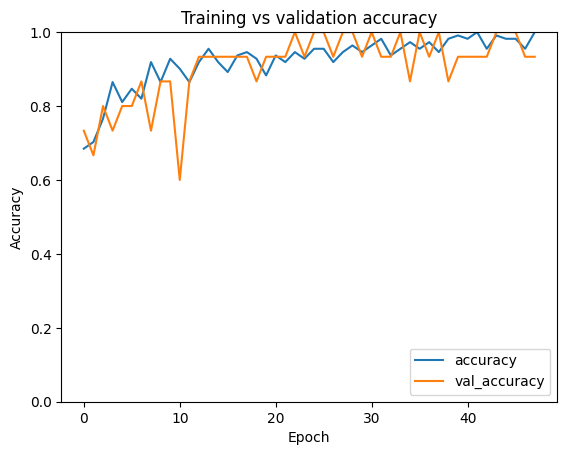

In [ ]:
# Graficando la exactitud de entrenamiento vs exactitud de validación durante el entrenamiento
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.legend(loc = 'lower right')
plt.title("Training vs validation accuracy")

Text(0.5, 1.0, 'Training vs validation loss')

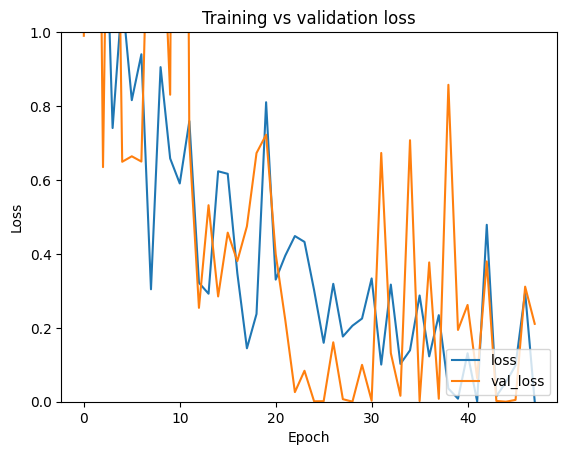

In [ ]:
# Graficando la pérdida de entrenamiento vs pérdida de validación durante el entrenamiento
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0,1])
plt.legend(loc = 'lower right')
plt.title("Training vs validation loss")

In [ ]:
# Cargando modelo al mejor punto de control
model_best = load_model('/content/drive/My Drive/mejor_modelo_CNN_2.hdf5')
test_loss, test_acc = model_best.evaluate(test_data)

8/8 [==============================] - 4s 79ms/step - loss: 0.8923 - accuracy: 0.9167


# **Predicciones**
Se realizaron 5 predicciones con la CNN entrenada para ver gráficamente los resultados.

In [ ]:
model = load_model('/content/drive/My Drive/CNN_modelo_2.h5')

La función de activación de la capa de salida es Softmax, por lo que las salidas o predicciones son en forma de probabilidades. Se definió una función para devolver la clase de nombre de acuerdo a la clase con mayor probabilidad.

In [ ]:

def prediction_fn(path, _model):
    classes_dir = class_names
    # Loading Image
    img = image.load_img(path, target_size=(256,256))
    # Normalizing Image
    norm_img = image.img_to_array(img)/255
    # Converting Image to Numpy Array
    input_arr_img = np.array([norm_img])
    # Getting Predictions
    pred = np.argmax(_model.predict(input_arr_img))
    # Printing Model Prediction
    return classes_dir[pred]

Se crearon aleatoriamente matrices aleatorias que contenían 3 o 2 rutas de imagen para cada una de las 2 clases posibles.

In [ ]:
np.random.seed(3)

# Imagenes random from no.venenosa
novenenosa_vector = []
for i in range(2):
  path_novenenosa = test_path+'/noVenenosa/'
  random_im = np.random.choice(os.listdir(path_novenenosa))
  novenenosa_vector.append(path_novenenosa+random_im)

# Imagenes random from veneosa
venenosa_vector = []
for i in range(3):
  path_venenosa = test_path+'/venenosa/'
  random_im = np.random.choice(os.listdir(path_venenosa))
  venenosa_vector.append(path_venenosa+random_im)

Las 5 predicciones se muestran a continuación. Y la imagen de la primera predicción se muestra al final.

1/1 [==============================] - 4s 4s/step
Prediction of /content/drive/My Drive/DatasetAug/test/noVenenosa/Copia de Captura de pantalla 2023-05-23 233648 (2).png 
The CNN predicts no.venenosa 
And in reality is no venenosa

1/1 [==============================] - 0s 37ms/step
Prediction of /content/drive/My Drive/DatasetAug/test/noVenenosa/Copia de Captura de pantalla 2023-05-23 235054 (1).png 
The CNN predicts venenosa 
And in reality is no venenosa

1/1 [==============================] - 0s 46ms/step
Prediction of /content/drive/My Drive/DatasetAug/test/venenosa/Copia de snake-bites-1 (1).jpg 
The CNN predicts venenosa 
And in reality is venenosa

1/1 [==============================] - 0s 39ms/step
Prediction of /content/drive/My Drive/DatasetAug/test/venenosa/Copia de snake-bites-1 (2).jpg 
The CNN predicts venenosa 
And in reality is venenosa

1/1 [==============================] - 0s 38ms/step
Prediction of /content/drive/My Drive/DatasetAug/test/venenosa/Copia de images (1

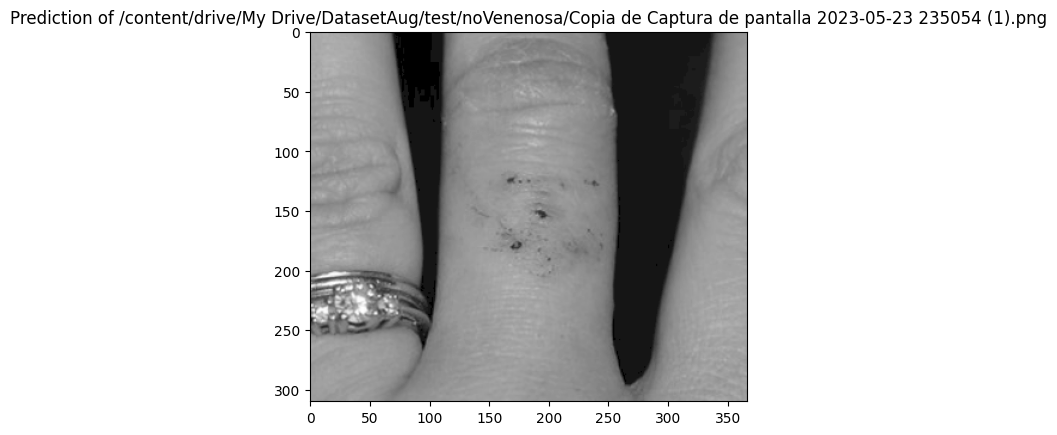

In [ ]:
for i in novenenosa_vector:
  true = prediction_fn(i,model)
  print("Prediction of",i, "\nThe CNN predicts",true,"\nAnd in reality is no venenosa\n")
  test_im = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
  plt.imshow(test_im, cmap='gray')
  plt.title("Prediction of "+ i)

for i in venenosa_vector:
  true = prediction_fn(i,model)
  print("Prediction of",i, "\nThe CNN predicts",true,"\nAnd in reality is venenosa\n")



---

### ***R E F E R E N C E S***
[1] A. Gholamy, V. Kreinovich, and O. Koshleva, “Why 70/30 or 80/20
relation between training and testing sets: A pedagogical explanation,”
Tech. Rep. UTEP-CS-18-09, The University of Texas at El Paso, Feb.
2018.

[2] A. Ghosh, A. Sufian, F. Sultana, A. Chakrabarti, and D. De, Fundamental
Concepts of Convolutional Neural Network, pp. 519–567. 01 2020.

[3] M. Hossin and M. N. Sulaiman, “A review on evaluation metrics for data
classification evaluations,” vol. 2, pp. 01–11, Mar. 2015.

[4] T. Tieleman and G. Hinton, “Divide the gradient by a running average
of its recent magnitude.” COURSERA: Neural Networks for Machine
Learning. Accessed: 2022-11-20

[5] Keras, “InceptionResNetV2” https://keras.io/api/applications/inceptionresnetv2/. Accessed: 2022-11-15.

[6] GitHub, “split-folders 0.5.1” https://github.com/jfilter/split-folders. Accessed: 2022-11-15.